# Introduction\n

Ce notebook a été réalisé sur visual studio avec python 3.12.4 et un pluging jupypter
Le code a été developpé et ordonnée sous la forme d'une mini-application. Pour des questions de lisibilité les fonctions sont ségmentées et séquencées
Git a été utilisé pour le versionning et travailler sur différents PC/cloud

Afin que le notebook génère tous les fichiers/slides, il faut utiliser windows et avoir la structure suivante  
/Monprojet/  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│├── /Dataset/  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;││├── EdStatsCountry.csv  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;││├── EdStatsCountry-Series.csv  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;││├── EdStatsData.csv  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;││├── EdStatsFootNote.csv  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;││├── EdStatsSeries.csv  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;││  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│├── /data/  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│├── /graph/  



# Import des Dataframes et premier niveau d'analyse

Dans cette section, nous allons importer les datasets sous forme de dataframes et nous allons faire une analyse pas à pas de leur structure

## Import de tous les datasets d'un répertoire sous forme de dataframes

Ces fonctions localisent le répertoire racine du notebook Jupyter et importent tous les datasets du répertoire './Dataset'. Elles nomment les DataFrames en conséquence et, si tout se charge correctement, elles affichent les cinq premières lignes de chaque DataFrame chargé. 

In [188]:
import os
import pandas as pd


# Adjust display options to show all columns
pd.set_option('display.max_columns', 5)
pd.set_option('display.expand_frame_repr', False)

# Relative path to the dataset directory
dataset_directory = 'Dataset'

# Get the current working directory (notebook's directory)
notebook_directory = os.getcwd()

# Construct full path to the dataset directory
directory = os.path.join(notebook_directory, dataset_directory)

# Check if the dataset directory exists
if not os.path.exists(directory):
    print(f"Error: Directory '{directory}' does not exist.")
else:
    # List all files in the dataset directory
    files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]

    # Dictionary to store DataFrames
    dfs = {}

    # Function to display loaded DataFrames
    def show_loaded_dfs(df_names=None):
        """
        Displays the head of the loaded DataFrames.
        
        Parameters:
        - df_names (list): Optional list of DataFrame names to display. If None, all DataFrames are displayed.
        """
        print("Currently loaded DataFrames:")
        if df_names is None:
            for name, df in dfs.items():
                print(f"DataFrame for file '{name}':")
                print(df.head())
                print("\n")
        else:
            for name in df_names:
                if name in dfs:
                    print(f"DataFrame for file '{name}':")
                    print(dfs[name].head())
                    print("\n")
                else:
                    print(f"DataFrame '{name}' not found in the loaded DataFrames.\n")

    # Function to preprocess DataFrames by dropping empty columns
    def preprocess_df(df):
        # Drop columns that are entirely empty
        return df.dropna(axis=1, how='all')

    # Load each file into a DataFrame, preprocess, and create dynamic variables
    for file in files:
        file_name = os.path.splitext(file)[0]
        file_path = os.path.join(directory, file)
        df = pd.read_csv(file_path)  # Adjust if not CSV
        df = preprocess_df(df)  # Preprocess the DataFrame
        dfs[file_name] = df
        globals()[file_name] = df  # Create a dynamic variable in the global namespace

    

    # Example usage
    # show_loaded_dfs()  # To display all DataFrames
    # show_loaded_dfs(['EdStatsCountry', 'EdStatsData'])  # To display specific DataFrames


## Resultat du script d'import

In [189]:
# Show loaded DataFrames
show_loaded_dfs()

Currently loaded DataFrames:
DataFrame for file '.gitignore':
             *
0  !.gitignore


DataFrame for file 'EdStatsCountry':
  Country Code   Short Name  ... Latest trade data Latest water withdrawal data
0          ABW        Aruba  ...            2012.0                          NaN
1          AFG  Afghanistan  ...            2012.0                         2000
2          AGO       Angola  ...               NaN                         2005
3          ALB      Albania  ...            2012.0                         2006
4          AND      Andorra  ...            2006.0                          NaN

[5 rows x 31 columns]


DataFrame for file 'EdStatsCountry-Series':
  CountryCode         SeriesCode                                        DESCRIPTION
0         ABW        SP.POP.TOTL  Data sources : United Nations World Population...
1         ABW        SP.POP.GROW  Data sources: United Nations World Population ...
2         AFG        SP.POP.GROW  Data sources: United Nations World

## Analyse des Colonnes

Nous allons analyser les colonnes de chaque DataFrame pour déterminer leur type, leur taux de remplissage, la présence de valeurs nulles, les faux "null" et déterminer des jointures possibles.


In [190]:
# Adjust display options to show all columns
pd.set_option('display.max_columns', 10)
pd.set_option('display.expand_frame_repr', False)

def analyze_column(col):
    col_data = col.dropna()
    col_dtypes = col.dtypes
    
    if col_data.empty:
        col_type = 'NaN'
        fill_percentage = 0.0
        nan_percentage = 100.0
        bad_null_percentage = 0.0
    else:
        type_counts = col_data.apply(lambda x: type(x).__name__).value_counts(normalize=True) * 100
        if len(type_counts) == 1:
            if type_counts.index[0] != 'NaN':
                max_length = col_data.apply(lambda x: len(str(x))).max()
                col_type = f"{type_counts.index[0]}({max_length})"
            else:
                col_type = type_counts.index[0]
        else:
            # If multiple types are present, compute errorType with percentages
            error_type_details = ', '.join([f"{t}: {p:.2f}%" for t, p in type_counts.items()])
            col_type = f"errorType({error_type_details})"
        
        fill_percentage = col_data.size / col.size * 100
        nan_percentage = col.isna().sum() / col.size * 100
        
        # Check for other forms of null values
        bad_null_count = col.isin(['', 'None', 'NULL', 'null']).sum()
        bad_null_percentage = bad_null_count / col.size * 100

    return {
        'Column Name': col.name,
        'Dtype': col_dtypes,
        'Type': col_type,
        'Fill Percentage': fill_percentage,
        'NaN Percentage': nan_percentage,
        'Bad Null Percentage': bad_null_percentage
    }

def analyze_dataframe(df):
    columns_info = []
    num_rows = len(df)
    for col_name in df.columns:
        col_info = analyze_column(df[col_name])
        columns_info.append(col_info)
    df_info = pd.DataFrame(columns_info)
    return df_info, num_rows

def create_metadata_dfs(dfs):
    metadata_dfs = {}
    for df_name, df in dfs.items():
        metadata_df, num_rows = analyze_dataframe(df)
        metadata_dfs[f'metadata_{df_name} {df.shape}'] = metadata_df
    return metadata_dfs

# Function to display metadata DataFrames
def display_metadata_dfs(metadata_dfs):
    for name, metadata_df in metadata_dfs.items():
        print(f"Metadata for {name}:")
        print(metadata_df)
        print("\n")

# Analyze DataFrames and create metadata DataFrames
metadata_dfs = create_metadata_dfs(dfs)



# Save the combined metadata DataFrame to a CSV file
combined_metadata = pd.concat(metadata_dfs.values(), keys=metadata_dfs.keys()).reset_index(level=0).rename(columns={'level_0': 'DataFrame'})
combined_metadata.to_csv('data/combined_metadata.csv', index=False)

## Resultat du script d'analyse des colonnes

In [191]:
# Display the metadata DataFrames
display_metadata_dfs(metadata_dfs)

Metadata for metadata_.gitignore (1, 1):
  Column Name   Dtype     Type  Fill Percentage  NaN Percentage  Bad Null Percentage
0           *  object  str(11)            100.0             0.0                  0.0


Metadata for metadata_EdStatsCountry (241, 31):
                                          Column Name    Dtype       Type  Fill Percentage  NaN Percentage  Bad Null Percentage
0                                        Country Code   object     str(3)       100.000000        0.000000                  0.0
1                                          Short Name   object    str(46)       100.000000        0.000000                  0.0
2                                          Table Name   object    str(46)       100.000000        0.000000                  0.0
3                                           Long Name   object    str(73)       100.000000        0.000000                  0.0
4                                        2-alpha code   object     str(2)        98.755187        1

## Analyse des doublons et des possibles clefs de jointure via un script
Nous allons analyser les DataFrames pour identifier les doublons et déterminer des clés primaires et/ou composites potentielles. Ensuite, nous allons tester ces clés pour vérifier leur unicité et leur adéquation en tant que clés de jointure.

In [192]:
def check_duplicates(dfs, ignore_fields={}, mandatory_fields={}):
    """
    Checks for duplicate rows in the DataFrames and if no raw duplicates are found, checks for composite key duplicates.
    
    Parameters:
    - dfs (dict): Dictionary of DataFrames to check.
    - ignore_fields (dict): Dictionary where keys are DataFrame names and values are lists of column names to ignore.
    - mandatory_fields (dict): Dictionary where keys are DataFrame names and values are lists of column names to use as composite keys.
    
    Returns:
    - result (dict): Dictionary where keys are DataFrame names and values are tuples containing the number of raw duplicate rows and composite key duplicate rows.
    """
    result = {}
    
    for df_name, df in dfs.items():
        if df_name in ignore_fields:
            # Drop the specified columns to ignore
            df_to_check = df.drop(columns=ignore_fields[df_name], errors='ignore')
        else:
            df_to_check = df
        
        # Find raw duplicates
        duplicate_rows = df_to_check.duplicated(keep=False)
        num_raw_duplicates = duplicate_rows.sum()
        
        # Check for composite key duplicates if no raw duplicates are found
        num_composite_key_duplicates = 0
        if num_raw_duplicates == 0 and df_name in mandatory_fields:
            composite_key_columns = mandatory_fields[df_name]
            if set(composite_key_columns).issubset(df.columns):
                composite_key_duplicates = df.duplicated(subset=composite_key_columns, keep=False)
                num_composite_key_duplicates = composite_key_duplicates.sum()
        
        # Add to result
        result[df_name] = (num_raw_duplicates, num_composite_key_duplicates)
        
        print(f"DataFrame '{df_name}': {num_raw_duplicates} raw duplicate rows found, {num_composite_key_duplicates} composite key duplicate rows found")
    
    return result

# Example usage
ignore_fields = {
    'EdStatsCountry-Series': ['DESCRIPTION'],
    'EdStatsCountry': ['Special Notes'],
    'EdStatsFootNote': ['DESCRIPTION'],
    'EdStatsSeries':['Short definition']
}

mandatory_fields = {
    'EdStatsCountry-Series': ['CountryCode','SeriesCode'],
    'EdStatsCountry': ['Country Code','Table Name'],
    'EdStatsData': ['Country Code','Indicator Code'],
    'EdStatsFootNote':['CountryCode','SeriesCode','Year'],
    'EdStatsSeries':['Series Code','Indicator Name']
}


## Resultat du script d'analyse des clefs

In [193]:
# Assuming 'dfs' is the dictionary of DataFrames already loaded
duplicate_summary = check_duplicates(dfs, ignore_fields, mandatory_fields)

DataFrame '.gitignore': 0 raw duplicate rows found, 0 composite key duplicate rows found
DataFrame 'EdStatsCountry': 0 raw duplicate rows found, 0 composite key duplicate rows found
DataFrame 'EdStatsCountry-Series': 0 raw duplicate rows found, 0 composite key duplicate rows found
DataFrame 'EdStatsData': 0 raw duplicate rows found, 0 composite key duplicate rows found
DataFrame 'EdStatsFootNote': 0 raw duplicate rows found, 0 composite key duplicate rows found
DataFrame 'EdStatsSeries': 0 raw duplicate rows found, 0 composite key duplicate rows found


# Simplification des DataFrames en fonction de KPIs intéressants

Maintenant que nous avons une vision globale de la structure et de la qualité des datasets, nous allons créer un subset de données en nous focalisant sur le besoin initial. 
- **"Nous sommes une start-up de formations en ligne qui veut s'étendre à l'international et nous visons un public francophone/anglophone de 15 à 24 ans pour des formations de niveau lycée à universitaire."

## Étape 1 : Filtrage par exclusion des KPIs pertinents
Nous allons adapter le script de filtrage pour exclure les indicateurs non-pertinents en fonction de notre public cible et nos besoins spécifiques.

In [194]:
import re

def filter_and_save_kpis(EdStatsSeries):
    # List of terms to ignore in the 'Topic'
    ignore_list = ['Economic Policy', 'Education Equality', 'SABER', 'Early Childhood Education', 'Health', 'Social Protection', 'Population', 'Teachers', 'Pre-Primary', 'Primary', 'Learning Outcomes', 'Literacy']
    ignore_pattern = '|'.join(ignore_list).replace('%', '.*')

    # List of terms to ignore in the 'Indicator Name' for lower school levels
    school_level_ignore_list = ['1st', '2nd', '3rd', '4th', '5th', '6th', 'primary', 'No Education', 'Grade']
    school_level_ignore_pattern = '|'.join(school_level_ignore_list)

    # List of terms to ignore for gender-related entries
    gender_ignore_list = ['Female', 'Male', 'gender parity index', 'male (%)', 'toilets', 'male (number)', 'male (years)']
    gender_ignore_pattern = '|'.join(re.escape(term) for term in gender_ignore_list)

    # Define the pattern to exclude entries related to ages over 24 or under 15
    age_pattern = r'age\s*(?:[0-9]|1[0-4]|2[5-9]|[3-9]\d|\d{3,})|\bage\s*(?:[0-9]\+|1[0-4]\+|2[5-9]\+|[3-9]\d\+|\d{3,}\+)|\bage\s*(?:[0-9]-\d{2,}|1[0-4]-\d{2,}|2[5-9]-\d{2,}|[3-9]\d-\d{2,}|\d{3,}-\d{2,})'

    # Define the pattern to keep rows with 'Learning Outcomes' if 'Indicator Name' contains 'French' or 'English'
    language_pattern = r'French|English'

    # Filter rows based on 'Topic' and 'Indicator Name', while keeping 'Learning Outcomes' with 'French' or 'English'
    filtered_df = EdStatsSeries[
        (~EdStatsSeries['Topic'].str.contains(ignore_pattern, regex=True) |
         ((EdStatsSeries['Topic'] == 'Learning Outcomes') & EdStatsSeries['Indicator Name'].str.contains(language_pattern, regex=True, case=False))) &
        ~EdStatsSeries['Indicator Name'].str.contains(age_pattern, regex=True, case=False) &
        ~EdStatsSeries['Indicator Name'].str.contains(school_level_ignore_pattern, regex=True, case=False) &
        ~EdStatsSeries['Indicator Name'].str.contains(gender_ignore_pattern, regex=True, case=False)
    ][['Topic', 'Series Code', 'Indicator Name', 'Short definition']].drop_duplicates()

    # Save the distinct combinations to a CSV file
    filtered_df.to_csv(r'data/interesting_kpis.csv', index=False)

    
    return filtered_df

In [195]:
# call the function
filtered_kpis = filter_and_save_kpis(EdStatsSeries)

# Display the shape of the filtered DataFrame
print(f"Shape of the filtered DataFrame: {filtered_kpis.shape}")


Shape of the filtered DataFrame: (190, 4)


Fabuleux ! Nous sommes passés d'une liste de 3665 indicateurs à une liste de 190. Il serait ainsi plus facile de faire une sélection.

## Étape 2 : Filtrage manuel en fonction d'un scénario

### Pour faire une formation en ligne, les apprenants ont besoin
- d'une connexion à internet de bonne qualité
- d'un appareil pour y accéder (PC, smartphone, tablette, ... )
  => Recherche d' un ou plusieurs indicateurs sur ces sujets d'infrastructure

### Pour une expansion internationale facile, il faut une langue commune entre les apprenants et le centre de formation
  => Recherche d'un indicateur sur le niveau de langue en français (ou anglais)

### Il nous faut un contexte socio-économique et pouvoir se projeter avec
- Des informations sur la démographie et son évolution sur au moins 5-10 ans dans la tranche de population cible
- Des informations sur l'évolution du taux de poursuite d'études pour les niveaux lycée / université
- Des informations sur l'évolution du budget pour l'éducation dans la tranche ciblée
- Des informations sur l'évolution du PIB du pays
  => Recherche d'un ensemble d'indicateurs pour avoir une vision socio-économique et comprendre des opportunités de marché de façon générique

### Et la cerise sur le gâteau
- Tout indicateur permettant de mieux cerner les besoins et les désirs de la génération future afin de s'assurer que les valeurs de l'entreprise sont en phase avec le futur marché
  => 2 indicateurs max pour raconter une histoire

## Catégories et Top 5 KPIs

### 1. Connexion à Internet et accès à des appareils pour formation en ligne
- **Internet users (per 100 people)** (IT.NET.USER.P2)
- **Personal computers (per 100 people)** (IT.CMP.PCMP.P2)

### 2. Niveau de langue en français ou anglais
Pour cette catégorie, nous n'avons pas d'indicateur direct dans la liste fournie. Cependant, nous pouvons considérer les indicateurs de mobilité étudiante pour évaluer l'internationalisation des étudiants, ce qui pourrait refléter l'utilisation des langues internationales telles que l'anglais.

- **Total inbound internationally mobile students, both sexes** (UIS.MS.56.T)
- **Net flow ratio of internationally mobile students (inbound - outbound), both sexes (%)** (UIS.MENFR.56)
- **Inbound mobility rate, both sexes (%)** (UIS.MSEP.56)

### 3. Contexte socio-économique et projections
#### 3.1. Démographie et évolution
- **Projection: Population in thousands by highest level of educational attainment. Lower Secondary. Total** (PRJ.POP.ALL.2.MF)
- **Projection: Population in thousands by highest level of educational attainment. Upper Secondary. Total** (PRJ.POP.ALL.3.MF)
- **Projection: Population in thousands by highest level of educational attainment. Post Secondary. Total** (PRJ.POP.ALL.4.MF)

#### 3.2. Taux de poursuite d'études
- **Gross enrolment ratio, secondary, both sexes (%)** (SE.SEC.ENRR)
- **Gross enrolment ratio, tertiary, both sexes (%)** (SE.TER.ENRR)
- **Graduates from tertiary education, both sexes (number)** (SE.TER.GRAD)

#### 3.3. Budget pour l'éducation
- **Expenditure on secondary as % of government expenditure on education (%)** (SE.XPD.SECO.ZS)
- **Expenditure on tertiary as % of government expenditure on education (%)** (SE.XPD.TERT.ZS)
- **Government expenditure on education as % of GDP (%)** (SE.XPD.TOTL.GD.ZS)

#### 3.4. PIB du pays
Pour cette sous-catégorie, nous n'avons pas de KPI direct sur le PIB dans la liste fournie.
Nous irons chercher cette information plus tard pour envisager plusieurs scénarii

### 4. Besoins et désirs de la génération future
- **Share of youth not in education, employment or training, total (% of youth population)** (SL.UEM.NEET.ZS)
- **Percentage of students in secondary education enrolled in vocational programmes, both sexes (%)** (SE.SEC.ENRL.VO.ZS)


In [196]:


# List of Series Codes based on selected indicators
codeserielist = [
    "IT.NET.USER.P2",  # Internet users (per 100 people)
    "IT.CMP.PCMP.P2",  # Personal computers (per 100 people)
    "UIS.MS.56.T",  # Total inbound internationally mobile students, both sexes
    "UIS.MENFR.56",  # Net flow ratio of internationally mobile students (inbound - outbound), both sexes (%)
    "UIS.MSEP.56",  # Inbound mobility rate, both sexes (%)
    "PRJ.POP.ALL.2.MF",  # Projection: Population in thousands by highest level of educational attainment. Lower Secondary. Total
    "PRJ.POP.ALL.3.MF",  # Projection: Population in thousands by highest level of educational attainment. Upper Secondary. Total
    "PRJ.POP.ALL.4.MF",  # Projection: Population in thousands by highest level of educational attainment. Post Secondary. Total
    "SE.SEC.ENRR",  # Gross enrolment ratio, secondary, both sexes (%)
    "SE.TER.ENRR",  # Gross enrolment ratio, tertiary, both sexes (%)
    "SE.TER.GRAD",  # Graduates from tertiary education, both sexes (number)
    "SE.XPD.SECO.ZS",  # Expenditure on secondary as % of government expenditure on education (%)
    "SE.XPD.TERT.ZS",  # Expenditure on tertiary as % of government expenditure on education (%)
    "SE.XPD.TOTL.GD.ZS",  # Government expenditure on education as % of GDP (%)
    "SL.UEM.NEET.ZS",  # Share of youth not in education, employment or training, total (% of youth population)
    "SE.SEC.ENRL.VO.ZS"  # Percentage of students in secondary education enrolled in vocational programmes, both sexes (%)
]


# Filter the data based on the provided list of Series Codes
reduced_kpis = filtered_kpis[filtered_kpis["Series Code"].isin(codeserielist)]

# Save the filtered data to a CSV file
reduced_kpis.to_csv('data/interesting_kpis_reduced.csv', index=False)

## Étape 3 : Application du filtrage à nos DataFrames
Une fois les KPIs pertinents identifiés, nous allons filtrer nos DataFrames pour ne conserver que les colonnes d'intérêt.

### Reduction d'EdStatsSeries

In [197]:
# Merge the datasets on specified columns
EdStatsSeries_reduced = pd.merge(EdStatsSeries, reduced_kpis, on=['Topic', 'Indicator Name', 'Series Code'])

# Save the reduced DataFrame to a CSV file
EdStatsSeries_reduced.to_csv('data/EdStatsSeries_reduced.csv', index=False)

# Print the shape of the DataFrame and confirm save
print(f"EdStatsSeries_reduced{EdStatsSeries_reduced.shape} saved to 'data/EdStatsSeries_reduced.csv'")

EdStatsSeries_reduced(16, 16) saved to 'data/EdStatsSeries_reduced.csv'


### Reduction d'EdStatsCountry

EdStatsCountry_reduced permet d'améliorer la visibilité en se focalisant sur les colonnes nécéssaires et suffisantes à notre étude.
De plus, il faut ajouter un tag pour distinguer les groupes et les pays.

In [198]:
# Define important columns
important_columns = [
    'Country Code', 'Short Name', 'Table Name', 'Long Name',
    'Region', 'Income Group'
]

# Reduce the DataFrame to only important columns
EdStatsCountry_reduced = EdStatsCountry[important_columns].copy()

# Add a 'Category' column to indicate if each entry is a 'Country' or 'Group'
def determine_category(row):
    if 'income' in str(row['Income Group']).lower():
        return 'Country'
    else:
        return 'Unknown'

# Use .loc to modify the DataFrame
EdStatsCountry_reduced.loc[:, 'Category'] = EdStatsCountry_reduced.apply(determine_category, axis=1)

# Save the reduced DataFrame with the category
EdStatsCountry_reduced.to_csv('data/EdStatsCountry_reduced.csv', index=False)

### Reduction d'EdStatsData et d'EdStatsFootNote
- `EdStatsData_reduced` : Contient uniquement les `Indicator Name` présents dans `EdStatsSeries_reduced`.
- `EdStatsFootNote_reduced` : Contient uniquement les `Series Code` présents dans `EdStatsSeries_reduced`.

In [199]:
# Filter the countries
country_codes = EdStatsCountry_reduced[EdStatsCountry_reduced['Category'] == 'Country']['Country Code']

# Reduction of EdStatsData
EdStatsData_reduced = EdStatsData[EdStatsData['Indicator Code'].isin(EdStatsSeries_reduced['Series Code'])]
EdStatsData_reduced = EdStatsData_reduced[EdStatsData_reduced['Country Code'].isin(country_codes)]

# Identify the necessary columns and year columns for EdStatsSeries_reduced
necessary_columns = ['Indicator Name', 'Indicator Code', 'Country Name', 'Country Code']
year_columns = ['2000','2001','2002','2003','2004','2005','2006','2007','2008','2009','2010','2011','2012','2013','2014','2015', '2016', '2017', '2020', '2025', '2030', '2035']

# Filter the DataFrame to retain only those columns
available_columns = [col for col in necessary_columns + year_columns if col in EdStatsData_reduced.columns]
EdStatsData_reduced = EdStatsData_reduced[available_columns]

# Reduction of EdStatsFootNote
EdStatsFootNote_reduced = EdStatsFootNote[EdStatsFootNote['SeriesCode'].isin(EdStatsSeries_reduced['Series Code'])]

# Save the reduced DataFrames
EdStatsData_reduced.to_csv('data/EdStatsData_reduced.csv', index=False)
EdStatsFootNote_reduced.to_csv('data/EdStatsFootNote_reduced.csv', index=False)

# Print the shape of the reduced DataFrames
print(f"EdStatsData_reduced {EdStatsData_reduced.shape} saved to 'data/EdStatsData_reduced.csv'")
print(f"EdStatsFootNote_reduced {EdStatsFootNote_reduced.shape} saved to 'data/EdStatsFootNote_reduced.csv'")


EdStatsData_reduced (3424, 26) saved to 'data/EdStatsData_reduced.csv'
EdStatsFootNote_reduced (21323, 4) saved to 'data/EdStatsFootNote_reduced.csv'


### Analyse graphique

> **Remarque :**
> - En raison de la limitation du projet, qui est de créer un code simple et de regrouper toutes les explications dans un seul notebook Jupyter, toutes les fonctions sont regroupées dans ce même notebook.
> - Après avoir expérimenté avec divers outils de visualisation tels que Seaborn et Matplotlib, j'ai constaté qu'il était possible de simplifier l'agrégation des données en prenant la dernière valeur disponible pour chaque pays et chaque KPI.
> - L'approche graphique se concentrera principalement sur des heatmaps, pour changer des habitudes de visualisation.

---

#### 1. Objectif de l'analyse
L'objectif de cette analyse graphique est de fournir une vue d'ensemble visuelle des indicateurs clés de performance (KPI) par pays. Cette approche permet d'identifier rapidement les tendances et les anomalies à travers différents pays et indicateurs.

#### 2. Méthodologie
- **Agrégation des données** : Pour chaque pays et chaque KPI, nous utilisons la dernière valeur disponible afin de garantir une analyse pertinente et à jour.
- **Heatmaps** : Les heatmaps sont utilisées pour visualiser les données de manière intuitive et identifier les points forts et les points faibles par pays et par indicateur.

#### 3. Bibliothèques utilisées
- **Pandas** : Pour la manipulation et l'analyse des données.
- **Seaborn** et **Matplotlib** : Pour la visualisation des données.

---

#### 4. Implémentation des fonctions



In [200]:
import seaborn as sns
import matplotlib.pyplot as plt
import textwrap
import numpy as np

# Function to extract the latest values for each indicator
def extract_latest_values(EdStatsData_reduced, EdStatsSeries_reduced, year_columns):
    unique_indicators = EdStatsSeries_reduced['Series Code'].unique()
    indicators_no_data = []
    combined_latest_values = pd.DataFrame(index=EdStatsData_reduced['Country Code'].unique())

    for indicator_code in unique_indicators:
        df_indicator = EdStatsData_reduced[EdStatsData_reduced['Indicator Code'] == indicator_code]

        if df_indicator[year_columns].isnull().all().all():
            indicators_no_data.append(indicator_code)
            continue

        heatmap_data = df_indicator.pivot_table(
            values=year_columns,
            index=['Country Code'],
            aggfunc='mean'
        )

        present_year_columns = [col for col in year_columns if col in heatmap_data.columns]

        if not present_year_columns:
            indicators_no_data.append(indicator_code)
            continue

        # Extract the latest values for the current indicator
        latest_values = heatmap_data.apply(lambda row: row.dropna().values[-1] if not row.dropna().empty else None, axis=1)
        combined_latest_values[indicator_code] = latest_values

    return combined_latest_values, indicators_no_data

# Function to calculate statistics and store in a DataFrame
def calculate_statistics(combined_latest_values, EdStatsSeries_reduced):
    statistics = []

    for indicator_code in combined_latest_values.columns:
        values = combined_latest_values[indicator_code].dropna()

        if values.empty:
            continue

        mean_val = values.mean()
        median_val = values.median()
        std_val = values.std()
        indicator_name = EdStatsSeries_reduced[EdStatsSeries_reduced['Series Code'] == indicator_code]['Indicator Name'].values[0]

        statistics.append({
            'Indicator Name': indicator_name,
            'Indicator Code': indicator_code,
            'Mean': mean_val,
            'Median': median_val,
            'Std Dev': std_val
        })

    return pd.DataFrame(statistics)

# Function to select top n countries for each income group based on the latest values of an indicator
def select_top_countries(EdStatsCountry_reduced, combined_latest_values, statistics_df, top_n=5):
    top_countries_dict = {}
    enriched_statistics = statistics_df.copy()
    income_groups = EdStatsCountry_reduced['Income Group'].unique()

    for index, row in statistics_df.iterrows():
        indicator_code = row['Indicator Code']
        top_countries_dict[indicator_code] = {}
        for income_group in income_groups:
            countries_in_group = EdStatsCountry_reduced[EdStatsCountry_reduced['Income Group'] == income_group]['Country Code']
            countries_in_group = countries_in_group[countries_in_group.isin(combined_latest_values.index)]
            
            latest_values_in_group = combined_latest_values.loc[countries_in_group].dropna(how='all')
            if not latest_values_in_group.empty:
                top_countries_in_group = latest_values_in_group[indicator_code].nlargest(top_n).index.tolist()
                top_countries_dict[indicator_code][income_group] = top_countries_in_group
                
                # Create a list to hold new rows
                new_rows = []
                for position, country_code in enumerate(top_countries_in_group, start=1):
                    new_rows.append({
                        'Indicator Name': row['Indicator Name'],
                        'Indicator Code': indicator_code,
                        'Income Group': income_group,
                        'Country Code': country_code,
                        'Country Rank': position,
                        'Value': latest_values_in_group.loc[country_code, indicator_code]
                    })
                
                # Convert the list of new rows to a DataFrame and concatenate it to enriched_statistics
                new_rows_df = pd.DataFrame.from_records(new_rows)
                enriched_statistics = pd.concat([enriched_statistics, new_rows_df], ignore_index=True)

    return top_countries_dict, enriched_statistics

# Function to draw histograms from statistics DataFrame
def draw_histograms_from_statistics(statistics_df, combined_latest_values):
    for index, row in statistics_df.iterrows():
        indicator_code = row['Indicator Code']
        indicator_name = row['Indicator Name']
        mean_val = row['Mean']
        median_val = row['Median']
        std_val = row['Std Dev']

        values = combined_latest_values[indicator_code].dropna()


        # Determine outlier threshold
        outlier_threshold = mean_val + 3 * std_val
        
        # Clip values to the outlier threshold
        clipped_values = np.clip(values, None, outlier_threshold)

        plt.figure(figsize=(10, 6))
        sns.histplot(values, kde=True, bins=20, color='blue', alpha=0.6)
        plt.axvline(mean_val, color='r', linestyle='--', label=f'Mean: {mean_val:.2f}')
        plt.axvline(median_val, color='g', linestyle='-', label=f'Median: {median_val:.2f}')
        plt.axvline(mean_val + std_val, color='b', linestyle=':', label=f'Std Dev (+): {mean_val + std_val:.2f}')
        plt.axvline(mean_val - std_val, color='b', linestyle=':', label=f'Std Dev (-): {mean_val - std_val:.2f}')
        plt.title(f'Histogram of {indicator_name} (Latest Values)')
        plt.xlabel('Value')
        plt.ylabel('Frequency')
        plt.legend()
        plt.tight_layout()

        # Add outliers count information
        num_outliers = (values > outlier_threshold).sum()
        if num_outliers > 0:
            plt.text(outlier_threshold, plt.ylim()[1] * 0.9, f'{num_outliers} outliers clipped', color='black')

        file_name = f"histogram_{indicator_code}.png"
        plt.savefig(f'data/graph/{file_name}')
        plt.close()

       

        # Plot log-transformed histogram if values span several orders of magnitude
        if np.all(values > 0) and (np.max(values) / np.min(values) > 100):
            log_values = np.log1p(values)
            plt.figure(figsize=(10, 6))
            sns.histplot(log_values, kde=True, bins=20, color='blue', alpha=0.6)
            log_mean_val = np.log1p(mean_val)
            log_median_val = np.log1p(median_val)
            log_std_val = np.std(log_values)
            plt.axvline(log_mean_val, color='r', linestyle='--', label=f'Log Mean: {log_mean_val:.2f}')
            plt.axvline(log_median_val, color='g', linestyle='-', label=f'Log Median: {log_median_val:.2f}')
            plt.axvline(log_mean_val + log_std_val, color='b', linestyle=':', label=f'Log Std Dev (+): {log_mean_val + log_std_val:.2f}')
            plt.axvline(log_mean_val - log_std_val, color='b', linestyle=':', label=f'Log Std Dev (-): {log_mean_val - log_std_val:.2f}')
            plt.title(f'Log-Transformed Histogram of {indicator_name} (Latest Values)')
            plt.xlabel('Log Value')
            plt.ylabel('Frequency')
            plt.legend()
            plt.tight_layout()

            log_file_name = f"log_histogram_{indicator_code}.png"
            plt.savefig(f'data/graph/{log_file_name}')
            plt.close()

In [201]:
# Extraction des dernières valeurs
combined_latest_values, indicators_no_data = extract_latest_values(EdStatsData_reduced, EdStatsSeries_reduced, year_columns)

# Calcul des statistiques et stockage dans un DataFrame
statistics_df = calculate_statistics(combined_latest_values, EdStatsSeries_reduced)
statistics_df.to_csv('data/graph/statistics.csv', index=False)

# Sélection des 20 meilleurs pays pour chaque groupe de revenus et enrichissement du DataFrame des statistiques
top_countries_dict, enriched_statistics_df = select_top_countries(EdStatsCountry_reduced, combined_latest_values, statistics_df, top_n=50)
enriched_statistics_df.to_csv('data/graph/enriched_statistics.csv', index=False)

# Dessiner les histogrammes à partir des statistiques calculées
draw_histograms_from_statistics(statistics_df, combined_latest_values)

In [202]:
def wrap_text(text, max_width, char_width=7):
    """Wrap text to fit within the max_width considering the average character width."""
    return "\n".join(textwrap.wrap(text, width=(max_width // char_width) - 20))

def plot_kpi_with_income_groups(df, metadata_df):
    kpis = df['Indicator Code'].unique()
    
    for kpi in kpis:
        fig, ax = plt.subplots(figsize=(12, 8))
        kpi_data = df[df['Indicator Code'] == kpi]

        # Get metadata for the title
        indicator_info = metadata_df[metadata_df['Series Code'] == kpi].iloc[0]
        indicator_name = indicator_info['Indicator Name']
        long_desc = indicator_info['Long definition']

        # Calculate dynamic wrapping width based on figure size
        fig_width_inch = fig.get_size_inches()[0] * fig.dpi
        wrapped_desc = wrap_text(long_desc, max_width=fig_width_inch)

        # Title at the top
        plt.suptitle(f'{kpi} : {indicator_name}', fontsize=12, ha='center')

        # Calculate dynamic y-position for description based on text height
        desc_height = wrapped_desc.count("\n") + 1
        desc_y_position = 0.955 - (desc_height * 0)  # Adjusting y-position

        # Place the description just under the title
        plt.figtext(0.05, desc_y_position, wrapped_desc, fontsize=10, va='top', ha='left', wrap=True)

        # Adjust the plot area to make room for the description
        plt.subplots_adjust(top=desc_y_position - 0.1)

        # Extract mean, median, and std dev for the KPI
        mean_value = kpi_data['Mean'].iloc[0]
        median_value = kpi_data['Median'].iloc[0]
        std_dev_value = kpi_data['Std Dev'].iloc[0]

        # Data calculation
        income_groups = kpi_data['Income Group'].unique()
        country_codes = []
        income_group_labels = []
        values = []

        for income_group in income_groups:
            group_data = kpi_data[kpi_data['Income Group'] == income_group]
            # Select top 5 countries by value
            group_data = group_data.nlargest(5, 'Value')
            group_country_codes = group_data['Country Code'].tolist()
            group_values = group_data['Value'].tolist()

            country_codes.extend(group_country_codes)
            values.extend(group_values)
            income_group_labels.extend([income_group] * len(group_country_codes))

            # Add more empty columns between income groups for more space
            country_codes.extend([''] * 3)
            values.extend([0] * 3)  # Use 0 instead of None for plotting
            income_group_labels.extend([''] * 3)

        # Remove trailing empty spaces added for spacing between groups
        if country_codes[-3:] == [''] * 3:
            country_codes = country_codes[:-3]
            values = values[:-3]
            income_group_labels = income_group_labels[:-3]

        # Ensure all values are numeric
        numeric_values = [v if isinstance(v, (int, float)) and not pd.isnull(v) else 0 for v in values]

        # Plot values
        ax.bar(range(len(country_codes)), numeric_values, tick_label=country_codes)
        plt.xticks(rotation=90)
        
        # Plot mean, median, and std dev
        plt.axhline(y=mean_value, color='r', linestyle='-', label=f'Mean: {mean_value:.2f}')
        plt.axhline(y=median_value, color='g', linestyle='--', label=f'Median: {median_value:.2f}')
        plt.axhline(y=mean_value + std_dev_value, color='b', linestyle=':', label=f'Std Dev (+): {mean_value + std_dev_value:.2f}')
        plt.axhline(y=mean_value - std_dev_value, color='b', linestyle=':', label=f'Std Dev (-): {mean_value - std_dev_value:.2f}')

        # Annotate income groups below the country codes
        for idx, group in enumerate(income_groups):
            group_indices = [i for i, x in enumerate(income_group_labels) if x == group]
            if group_indices:
                plt.text((group_indices[0] + group_indices[-1] - 1) / 2, 
                         plt.ylim()[0] - (plt.ylim()[1] - plt.ylim()[0]) * 0.1, 
                         group, 
                         ha='center', va='top', fontsize=10, color='black', rotation=0)

        plt.ylabel('Value')
        plt.legend()
        
        plt.tight_layout(rect=[0, 0, 1, 0.90])  # Adjust layout to make room for description
        plt.savefig(f'data/graph/{kpi}.png')
        plt.close()

In [203]:
# Call the function to plot data for each KPI
plot_kpi_with_income_groups(enriched_statistics_df, EdStatsSeries_reduced)

# Scoring

## Rappel du contexte
Pour répondre à la demande de Mark et déterminer les pays avec un fort potentiel pour les services de formation en ligne d'Academy, nous allons créer un système de scoring basé sur les indicateurs clés de performance (KPIs) mentionnés. Voici un plan détaillé pour accomplir cette tâche :

## Sélection et Pondération des KPIs

### Connexion à Internet et accès à des appareils : 30%
- Utilisateurs d'Internet (pour 100 personnes) : 15%
- Ordinateurs personnels (pour 100 personnes) : 15%

### Niveau de langue en français ou anglais : 20%
- Nombre total d'étudiants internationaux mobiles entrants : 10%
- Ratio net de flux d'étudiants internationaux mobiles : 5%
- Taux de mobilité des entrants : 5%

### Contexte socio-économique et projections : 40%
- Projections de population (secondaire, supérieur, post-secondaire) : 10%
- Taux brut de scolarisation (secondaire et tertiaire) : 10%
- Diplômés de l'enseignement tertiaire : 5%
- Dépenses en éducation secondaire et tertiaire (% du PIB) : 10%
- Dépenses totales en éducation (% du PIB) : 5%

### Besoins et désirs de la génération future : 10%
- Part des jeunes sans emploi, éducation ou formation : 5% (lower is better)
- Pourcentage d'étudiants en enseignement secondaire inscrits en programmes professionnels : 5%

## Calcul du Score

### Calculer un score pondéré pour chaque pays :
- Appliquer les poids définis à chaque indicateur pour obtenir un score global.

### Utiliser des poids pour refléter l'importance relative de chaque KPI :
- Les poids sont définis selon l'importance de chaque KPI dans l'évaluation.

## Visualisation des Résultats

### Générer un tableau de bord avec les scores des pays par groupe de revenus :
- Organiser les pays en groupes de revenus et afficher leurs scores.

### Utiliser des graphiques radar pour visualiser les performances des pays par rapport aux KPIs :
- Créer des graphiques radar pour chaque pays afin de comparer les performances selon les différents KPIs.

### Mettre en avant les pays avec les scores les plus élevés dans chaque groupe de revenus :
- Identifier et souligner les pays ayant les meilleurs scores pour chaque groupe de revenus.


## Étape 1 : Calcul du Score et visualisation d'un classement

In [204]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import pi

# Define the rank-to-score mapping function
def rank_to_score(rank):
    if pd.isna(rank) or rank > 20:  # If rank is NaN or greater than 20, return 0
        return 0
    if rank == 1:
        return 10
    elif 1 < rank <= 10:
        return 11 - rank
    else:
        return 0

# Adjust the rank if lower is better
def adjust_rank_if_lower_is_better(rank, kpi, max_rank=20):
    if kpi in lower_is_better:
        return max_rank - rank + 1
    return rank

# Define the KPI weights
weights = {
    'IT.NET.USER.P2': 0.15, 'IT.CMP.PCMP.P2': 0.15, 'UIS.MS.56.T': 0.10, 'UIS.MENFR.56': 0.05, 'UIS.MSEP.56': 0.05,
    'PRJ.POP.ALL.2.MF': 0.03, 'PRJ.POP.ALL.3.MF': 0.03, 'PRJ.POP.ALL.4.MF': 0.04, 'SE.SEC.ENRR': 0.05, 'SE.TER.ENRR': 0.05,
    'SE.TER.GRAD': 0.05, 'SE.XPD.SECO.ZS': 0.05, 'SE.XPD.TERT.ZS': 0.05, 'SE.XPD.TOTL.GD.ZS': 0.05, 'SL.UEM.NEET.ZS': 0.05, 'SE.SEC.ENRL.VO.ZS': 0.05
}

lower_is_better = {
    'SL.UEM.NEET.ZS': 1
}

# Calculate scores for each country based on ranks and weights
def calculate_country_scores(statistics_df, weights, lower_is_better):
    country_scores = {}
    
    for _, row in statistics_df.iterrows():
        country_code = row['Country Code']
        if pd.isnull(country_code):
            continue
        
        if country_code not in country_scores:
            country_scores[country_code] = 0
        
        for kpi, weight in weights.items():
            if kpi == row['Indicator Code']:
                rank = row['Country Rank']
                adjusted_rank = adjust_rank_if_lower_is_better(rank, kpi)
                score = rank_to_score(adjusted_rank)
                weighted_score = score * weight
                country_scores[country_code] += weighted_score
    
    return country_scores

# Calculate scores
country_scores = calculate_country_scores(enriched_statistics_df, weights, lower_is_better)

# Convert to DataFrame for easier manipulation
country_scores_df = pd.DataFrame(country_scores.items(), columns=['Country Code', 'Score'])

# Merge scores with metadata to get income groups and country names
merged_scores_df = pd.merge(country_scores_df, EdStatsCountry_reduced[['Country Code', 'Income Group', 'Short Name']], on='Country Code')

# Top Y countries for each income group
top_y = 5
income_groups = merged_scores_df['Income Group'].unique()
top_per_income_group = {}

for income_group in income_groups:
    group_data = merged_scores_df[merged_scores_df['Income Group'] == income_group]
    top_per_income_group[income_group] = group_data.nlargest(top_y, 'Score')

# Define colors for the top ranks (reversed order)
colors = ['#DEB887', '#CD7FCF', '#CD7F32', '#C0C0C0', '#FFD700']

# Plotting the enhanced dashboard
fig, axs = plt.subplots(1, len(income_groups), figsize=(20, 10))

fig_title = fig.suptitle(f'Top {top_y} Countries by Score for Each Income Group', fontsize=16)

# Top Y countries per income group with styled bar charts
for i, income_group in enumerate(income_groups):
    group_data = top_per_income_group[income_group]
    group_data = group_data.sort_values(by='Score', ascending=True)
    colors_to_use = colors[-len(group_data):] + ['#A9A9A9'] * (len(group_data) - len(colors[-len(group_data):]))
    
    bars = axs[i].barh(group_data['Short Name'], group_data['Score'], color=colors_to_use)
    axs[i].set_title(f'{income_group}')
    axs[i].set_xlabel('Score')
    
    # Remove spines for a cleaner look
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)
    axs[i].spines['left'].set_visible(False)
    axs[i].spines['bottom'].set_visible(True)

    # Add score labels at the end of the bars
    for bar, score in zip(bars, group_data['Score']):
        axs[i].text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2, f'{score:.2f}', va='center', ha='left')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(f'data/graph/Top{top_y}_Countries_by_Score_for_Each_Income_Group.png')
plt.close()


## Étape 2 : Points forts et points faibles pour chaque pays dans le TOP

In [205]:


# Define the KPI groups and their corresponding letters
kpi_groups = {
    'A: Connexion à Internet et accès à des appareils': ['IT.NET.USER.P2', 'IT.CMP.PCMP.P2'],
    'B: Niveau de langue en français ou anglais': ['UIS.MS.56.T', 'UIS.MENFR.56', 'UIS.MSEP.56'],
    'C: Contexte socio-économique et projections': ['PRJ.POP.ALL.2.MF', 'PRJ.POP.ALL.3.MF', 'PRJ.POP.ALL.4.MF', 'SE.SEC.ENRR', 'SE.TER.ENRR', 'SE.TER.GRAD', 'SE.XPD.SECO.ZS', 'SE.XPD.TERT.ZS', 'SE.XPD.TOTL.GD.ZS'],
    'D: Besoins et désirs de la génération future': ['SL.UEM.NEET.ZS', 'SE.SEC.ENRL.VO.ZS']
}

# Function to calculate group scores for each country
def calculate_country_group_scores(statistics_df, kpi_groups, weights):
    country_group_scores = {}

    for country_code, country_data in statistics_df.groupby('Country Code'):
        group_scores = {}
        for group, kpis in kpi_groups.items():
            weighted_ranks = [rank_to_score(country_data[country_data['Indicator Code'] == kpi]['Country Rank'].values[0]) * weights[kpi]
                              for kpi in kpis if kpi in country_data['Indicator Code'].values]
            group_scores[group] = sum(weighted_ranks) if weighted_ranks else 0
        country_group_scores[country_code] = group_scores

    return country_group_scores

# Example usage
country_group_scores = calculate_country_group_scores(enriched_statistics_df, kpi_groups, weights)

# Convert to DataFrame for easier manipulation
country_group_scores_df = pd.DataFrame(country_group_scores).T
country_group_scores_df.reset_index(inplace=True)
country_group_scores_df.rename(columns={'index': 'Country Code'}, inplace=True)

# Merge scores with metadata to get income groups and country names
merged_group_scores_df = pd.merge(country_group_scores_df, EdStatsCountry_reduced[['Country Code', 'Income Group', 'Short Name']], on='Country Code')

# Calculate total score by summing group scores
merged_group_scores_df['Calculated Total Score'] = merged_group_scores_df[list(kpi_groups.keys())].sum(axis=1)

# Merge scores from the other DataFrame
merged_group_scores_df = pd.merge(merged_group_scores_df, merged_scores_df[['Country Code', 'Score']], on='Country Code', suffixes=('_group', '_total'))

# Top 3 countries for each income group
top_radar_n = 3
top_per_income_group = {group: merged_group_scores_df[merged_group_scores_df['Income Group'] == group].nlargest(top_radar_n, 'Score') for group in merged_group_scores_df['Income Group'].unique()}

# Function to plot radar chart for KPI groups
def plot_radar_chart(df, id_column, ax, max_values=None, padding=1.25):
    categories = df._get_numeric_data().columns.tolist()
    labels = ['A', 'B', 'C', 'D']
    data = df[categories].to_dict(orient='list')
    ids = df[id_column].tolist()
    if max_values is None:
        max_values = {key: padding * max(value) for key, value in data.items()}

    num_vars = len(data.keys())
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]
    
    for i, model_name in enumerate(ids):
        values = [data[key][i] for key in data.keys()]
        values += values[:1]
        ax.plot(angles, values, label=model_name, linewidth=2)
        ax.fill(angles, values, alpha=0.25)
    
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels)
    
    ax.yaxis.set_ticks_position('right')
    ax.grid(True)
    ax.set_yticklabels([])


# Function to create slides for top countries in each income group
def create_slides(top_per_income_group, kpi_groups, weights):
    for income_group, top_countries in top_per_income_group.items():
        for rank, (_, country_row) in enumerate(top_countries.iterrows(), start=1):
            country_code = country_row['Country Code']
            country_name = country_row['Short Name']

            # Prepare data for radar chart
            kpi_values = enriched_statistics_df[enriched_statistics_df['Country Code'] == country_code].set_index('Indicator Code')['Country Rank'].to_dict()
            kpi_data = {group: sum(rank_to_score(kpi_values.get(kpi, np.nan)) * weights[kpi] for kpi in kpis) for group, kpis in kpi_groups.items()}
            kpi_df = pd.DataFrame([kpi_data])
            kpi_df['Country'] = country_name

            # Plotting the slide
            fig, ax = plt.subplots(figsize=(10, 5), subplot_kw=dict(polar=True))
            fig.suptitle(f'{country_name} - {country_code} - {income_group} TOP {top_radar_n}', fontsize=16, y=1.0)

            # Plot radar chart
            plot_radar_chart(kpi_df, id_column='Country', ax=ax)

            # Display scores for KPI families and individual KPIs
            text_str = f'Rank {rank} in {income_group}\n\n'

            for i, (family, kpis) in enumerate(kpi_groups.items()):
                family_score = sum(rank_to_score(enriched_statistics_df[(enriched_statistics_df['Country Code'] == country_code) & (enriched_statistics_df['Indicator Code'] == kpi)]['Country Rank'].values[0]) * weights[kpi] for kpi in kpis)
                text_str += f'{list("ABCD")[i]}: {family.split(": ", 1)[1]} - {family_score:.2f}\n'
         
                for kpi in kpis:
                    if kpi in kpi_values:
                        kpi_rank = enriched_statistics_df[(enriched_statistics_df['Country Code'] == country_code) & (enriched_statistics_df['Indicator Code'] == kpi)]['Country Rank'].values[0]
                        kpi_score = rank_to_score(kpi_rank) * weights[kpi]
                        kpi_weight = weights[kpi] * 100
                        text_str += f'  - {kpi} ({kpi_weight}%): Rank {kpi_rank:.0f}\n'
                text_str += f'\n'


            ax.text(1.3, 0.45, text_str, fontsize=10, va='center', ha='left', color='black', transform=ax.transAxes)


            plt.tight_layout()
            plt.subplots_adjust(left=-0.4, right=1)
            plt.savefig(f'data/graph/{country_name}_{country_code}_TOP{top_radar_n}.png')
            plt.close()

create_slides(top_per_income_group, kpi_groups, weights)


## Étape 3 : Evolution des indicateurs au cous du temps pour chacuns des pays séléctionnés

In [206]:
# Function to determine if a KPI is percentage-based or measured "per 100" by checking the "Indicator Name" in metadata
def is_percentage_based(kpi_code, metadata_df):
    indicator_name = metadata_df[metadata_df['Series Code'] == kpi_code]['Indicator Name'].values
    if len(indicator_name) > 0:
        return '%' in indicator_name[0] or '100' in indicator_name[0]
    return False

# Function to plot KPI trends with standardized scales
def plot_kpi_trends_standardized(top_per_income_group, edstats_data_reduced, kpi_groups, years, metadata_df):

    
    for income_group, top_countries in top_per_income_group.items():
        for _, country_row in top_countries.iterrows():

            # Initialize flags to track if percentage-based or non-percentage-based KPIs are plotted
            has_percentage_kpis = False
            has_non_percentage_kpis = False

            country_code = country_row['Country Code']
            country_name = country_row['Short Name']

            # Create a figure for the current country
            fig, axs = plt.subplots(2, 2, figsize=(20, 20))
            fig.suptitle(f'{country_name} - KPI Trends over Years', fontsize=16)

            for i, (kpi_group, kpis) in enumerate(kpi_groups.items()):
                ax1 = axs[i // 2, i % 2]
                ax1.set_title(kpi_group.split(": ")[1])

                ax2 = ax1.twinx()

                has_valid_plot = False  # Track if anything valid was plotted

                for kpi in kpis:
                    kpi_data = edstats_data_reduced[(edstats_data_reduced['Country Code'] == country_code) & 
                                                    (edstats_data_reduced['Indicator Code'] == kpi)]
                    
                    if kpi_data.empty:
                        # Plot a zero line if no data is available for the KPI
                        ax1.plot([0] * len(years), label=f'{kpi} (No Data)', linestyle='-', marker='o')
                        continue

                    kpi_values = kpi_data.set_index('Country Code')[years].T
                    kpi_values = kpi_values.interpolate(method='linear', axis=0).fillna(0)  # Fill missing data with 0

                    kpi_name = metadata_df[metadata_df['Series Code'] == kpi]['Indicator Name'].values[0]

                    # Standardize and plot KPIs on the appropriate axis
                    if is_percentage_based(kpi, metadata_df):
                        # Fill null values with 0 and clip values at 100%
                        scaled_values = kpi_values.fillna(0).clip(upper=100)
                        ax1.plot(scaled_values, label=kpi_name, linestyle='-', marker='o')
                        has_percentage_kpis = True  # Mark that a percentage-based KPI is plotted
                    else:
                        # Fill null values with 0
                        kpi_values_filled = kpi_values.fillna(0)
                        max_val = kpi_values_filled.max().max()
                        if max_val == 0:  # Avoid division by zero
                            max_val = 1
                        # Normalize to 0-100 scale
                        scaled_values = kpi_values_filled
                        ax2.plot(scaled_values, label=kpi_name, linestyle='-', marker='x')
                        has_non_percentage_kpis = True  # Mark that a non-percentage-based KPI is plotted


                    has_valid_plot = True  # Mark that something was plotted

                if has_percentage_kpis:
                    ax1.set_ylabel('Percentage-Based KPI (0-100%)', color='blue')
                    ax1.tick_params(axis='y', colors='blue')
                else:
                    ax1.set_yticks([])  # Remove Y-ticks if no percentage-based KPI is plotted

                if has_non_percentage_kpis:
                    ax2.set_ylabel('Population-Based KPI (in Thousands)', color='green')
                    ax2.tick_params(axis='y', colors='green')
                else:
                    ax2.set_yticks([])  # Remove Y-ticks if no non-percentage-based KPI is plotted




                if has_valid_plot:
                    legend_height = 0.03
                    max_items = max(len(ax1.get_legend_handles_labels()[1]), len(ax2.get_legend_handles_labels()[1]))

                    base_position = -0.15 - (max_items -1) * legend_height

                    if has_percentage_kpis:
                        ax1.legend(loc='lower left', bbox_to_anchor=(-0.08, base_position - legend_height), fontsize=12)
                    if has_non_percentage_kpis:
                        ax2.legend(loc='lower left', bbox_to_anchor=(-0.08, base_position - (max_items + 1)*legend_height), fontsize=12)



                plt.xlabel('Year')

                # Set x-axis to show labels every 5 years
                ax1.set_xticks(ax1.get_xticks()[::5])

            # Add cross lines to separate the four subplots
            fig.subplots_adjust(hspace=0, wspace=0.2)
            for ax in axs.flatten():
                ax.axvline(x=len(years) // 2, color='white', linestyle='--', lw=0.5)
                ax.axhline(y=0, color='white', linestyle='--', lw=0.5)

            plt.tight_layout(rect=[0.05, 0, 1, 0.95])
            plt.savefig(f'data/graph/kpi_trends_{country_name}_{country_code}.png')
            plt.close()

# usage:
plot_kpi_trends_standardized(top_per_income_group, EdStatsData_reduced, kpi_groups, year_columns, EdStatsSeries_reduced)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

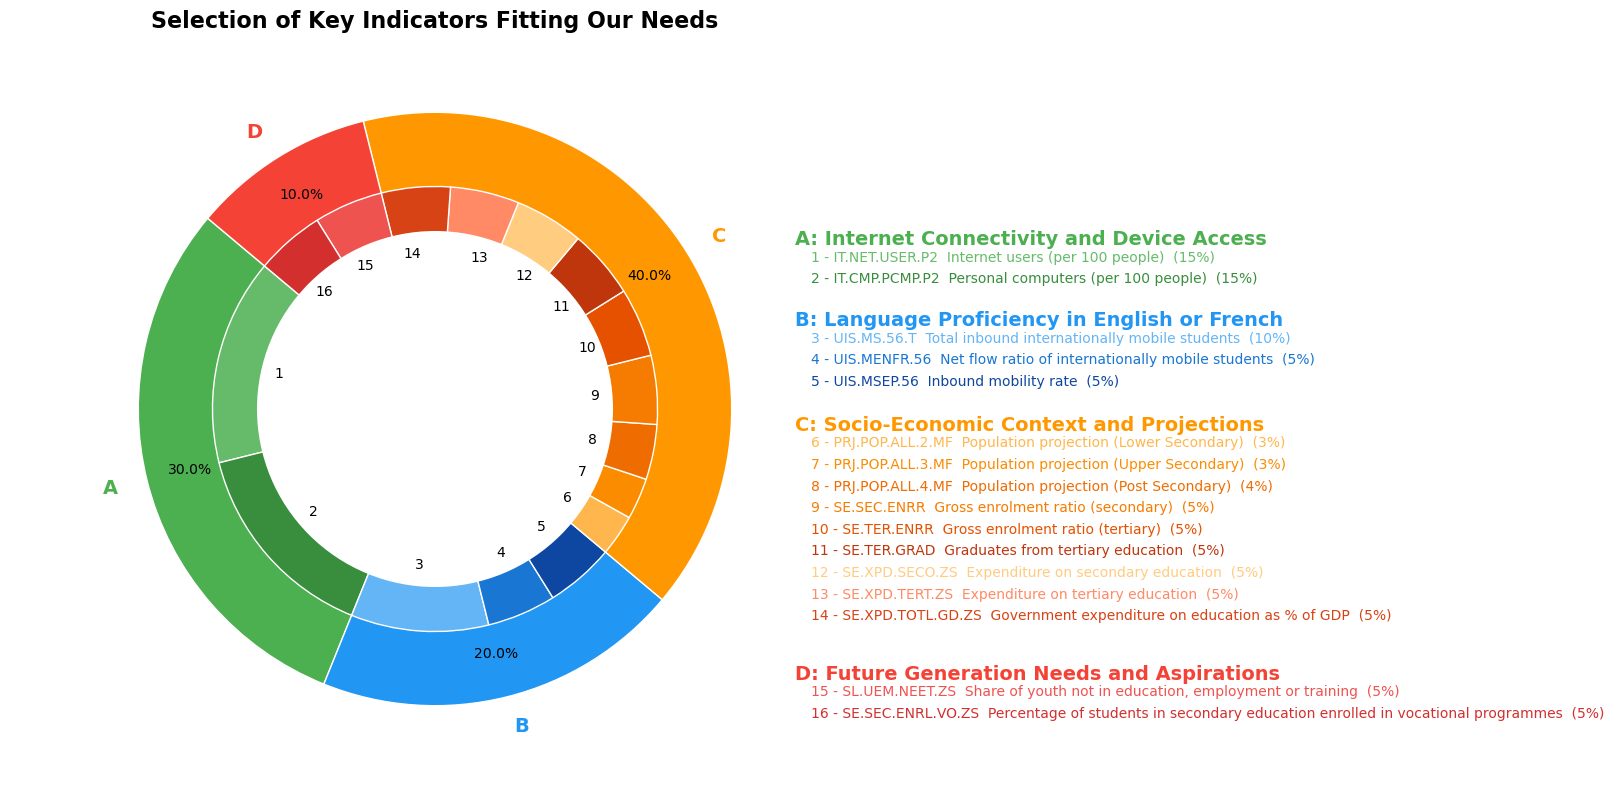

In [454]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Define the KPI groups and weights
kpi_groups = {
    'A': ['IT.NET.USER.P2', 'IT.CMP.PCMP.P2'],
    'B': ['UIS.MS.56.T', 'UIS.MENFR.56', 'UIS.MSEP.56'],
    'C': ['PRJ.POP.ALL.2.MF', 'PRJ.POP.ALL.3.MF', 'PRJ.POP.ALL.4.MF', 'SE.SEC.ENRR', 'SE.TER.ENRR', 'SE.TER.GRAD', 'SE.XPD.SECO.ZS', 'SE.XPD.TERT.ZS', 'SE.XPD.TOTL.GD.ZS'],
    'D': ['SL.UEM.NEET.ZS', 'SE.SEC.ENRL.VO.ZS']
}

weights = {
    'IT.NET.USER.P2': 0.15, 'IT.CMP.PCMP.P2': 0.15, 'UIS.MS.56.T': 0.10, 'UIS.MENFR.56': 0.05, 'UIS.MSEP.56': 0.05,
    'PRJ.POP.ALL.2.MF': 0.03, 'PRJ.POP.ALL.3.MF': 0.03, 'PRJ.POP.ALL.4.MF': 0.04, 'SE.SEC.ENRR': 0.05, 'SE.TER.ENRR': 0.05,
    'SE.TER.GRAD': 0.05, 'SE.XPD.SECO.ZS': 0.05, 'SE.XPD.TERT.ZS': 0.05, 'SE.XPD.TOTL.GD.ZS': 0.05, 'SL.UEM.NEET.ZS': 0.05, 'SE.SEC.ENRL.VO.ZS': 0.05
}

# Assign colors to the groups and their KPIs
group_colors = {
    'A': '#4CAF50',  # Green
    'B': '#2196F3',  # Blue
    'C': '#FF9800',  # Orange
    'D': '#F44336'   # Red
}

kpi_colors = {
    'IT.NET.USER.P2': '#66BB6A', 'IT.CMP.PCMP.P2': '#388E3C',  # Shades of green for A
    'UIS.MS.56.T': '#64B5F6', 'UIS.MENFR.56': '#1976D2', 'UIS.MSEP.56': '#0D47A1',  # Shades of blue for B
    'PRJ.POP.ALL.2.MF': '#FFB74D', 'PRJ.POP.ALL.3.MF': '#FB8C00', 'PRJ.POP.ALL.4.MF': '#EF6C00',
    'SE.SEC.ENRR': '#F57C00', 'SE.TER.ENRR': '#E65100', 'SE.TER.GRAD': '#BF360C',
    'SE.XPD.SECO.ZS': '#FFCC80', 'SE.XPD.TERT.ZS': '#FF8A65', 'SE.XPD.TOTL.GD.ZS': '#D84315',  # Shades of orange for C
    'SL.UEM.NEET.ZS': '#EF5350', 'SE.SEC.ENRL.VO.ZS': '#D32F2F'  # Shades of red for D
}

# Calculate total weights for each group
group_weights = {group: sum(weights[kpi] for kpi in kpis) for group, kpis in kpi_groups.items()}

# Calculate sizes for the groups and KPIs based on weights
group_sizes = [group_weights[group] for group in kpi_groups.keys()]
kpi_sizes = [weights[kpi] for kpi in [kpi for group in kpi_groups for kpi in kpi_groups[group]]]


# Plot text on the left side of the slide
fig, ax = plt.subplots(figsize=(16, 8))

# Adjust the position of the pie chart to the right
ax.set_position([0.5, 0.1, 0.35, 0.8])


# Pie chart, where the slices will be ordered and plotted counter-clockwise
wedges, texts, autotexts = ax.pie(
    group_sizes,
    labels=[f'{group}' for group in kpi_groups.keys()],
    colors=[group_colors[group] for group in kpi_groups.keys()],
    autopct='%1.1f%%',
    startangle=140,
    pctdistance=0.85,
    wedgeprops={'edgecolor': 'white'}
)

# Bold the group letters and change their color to match the pie slices
for text, group in zip(texts, kpi_groups.keys()):
    text.set_fontsize(14)
    text.set_fontweight('bold')
    text.set_color(group_colors[group])

# Add the inner circle for KPIs within groups
kpi_labels_numeric = [str(i + 1) for i in range(len(kpi_sizes))]

ax.pie(
    kpi_sizes,
    colors=kpi_colors_list,
    labels=kpi_labels_numeric,
    radius=0.75,
    labeldistance=0.7,
    startangle=140,
    wedgeprops={'edgecolor': 'white'}
)

# Add a white circle at the center to make it a donut chart
centre_circle = plt.Circle((0, 0), 0.60, fc='white')
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle.
ax.axis('equal')

# Adjust tight_layout for text positioning
plt.tight_layout(rect=[0, 0, 0.55, 1])

# Detailed KPI Information
kpi_info = {
    'A': [
        "1 - IT.NET.USER.P2  Internet users (per 100 people)  (15%)",
        "2 - IT.CMP.PCMP.P2  Personal computers (per 100 people)  (15%)"
    ],
    'B': [
        "3 - UIS.MS.56.T  Total inbound internationally mobile students  (10%)",
        "4 - UIS.MENFR.56  Net flow ratio of internationally mobile students  (5%)",
        "5 - UIS.MSEP.56  Inbound mobility rate  (5%)"
    ],
    'C': [
        "6 - PRJ.POP.ALL.2.MF  Population projection (Lower Secondary)  (3%)",
        "7 - PRJ.POP.ALL.3.MF  Population projection (Upper Secondary)  (3%)",
        "8 - PRJ.POP.ALL.4.MF  Population projection (Post Secondary)  (4%)",
        "9 - SE.SEC.ENRR  Gross enrolment ratio (secondary)  (5%)",
        "10 - SE.TER.ENRR  Gross enrolment ratio (tertiary)  (5%)",
        "11 - SE.TER.GRAD  Graduates from tertiary education  (5%)",
        "12 - SE.XPD.SECO.ZS  Expenditure on secondary education  (5%)",
        "13 - SE.XPD.TERT.ZS  Expenditure on tertiary education  (5%)",
        "14 - SE.XPD.TOTL.GD.ZS  Government expenditure on education as % of GDP  (5%)"
    ],
    'D': [
        "15 - SL.UEM.NEET.ZS  Share of youth not in education, employment or training  (5%)",
        "16 - SE.SEC.ENRL.VO.ZS  Percentage of students in secondary education enrolled in vocational programmes  (5%)"
    ]
}

# Add group and KPI descriptions with colored lines on the right
top_offset = 0.7  # Start position for text
spacing_per_group = 0.0010 # Space between each group
spacing_per_kpi = 0.027  # Space between each KPI

for i, (group, desc) in enumerate(description_texts.items()):
    fig.text(0.5, top_offset - (i)*100*spacing_per_group -(i)*(i)*(i)*(i)*(i)* spacing_per_group, f'{group}: {desc}', fontsize=14, ha='left', weight='bold', color=group_colors[group])
    for j, kpi_text in enumerate(kpi_info[group]):
        # Get the actual KPI code for color lookup
        kpi_code = kpi_text.split()[2]
        fig.text(0.51, top_offset - (i)*100*spacing_per_group - (i)*(i)*(i)*(i)*(i)* spacing_per_group - (j + 0.25) * spacing_per_kpi, kpi_text, fontsize=10, ha='left', va='top', color=kpi_colors[kpi_code])

plt.title('Selection of Key Indicators Fitting Our Needs', fontsize=16, weight='bold', ha='center')
plt.show()
